# 使用basemap可视化中国各地区离婚率
有很多的数据可视化需求是跟地图相关的，比如本文将会讨论的中国各个地区的离婚率数据。python有一个第三方库basemap是专门用来处理这一类数据可视化需求的。并且该库可以显示全球任意地方。绘制地图需要对应国家和地区的shape文件，这些文件可以从 https://gadm.org/download_country_v3.html 下载。在绘制中国地图是尤其不要忘记台湾的shape文件需要单独下载。下面我们就开始讨论使用basemap可视化中国各地区离婚率数据。
1. 从excel中读取数据
2. 制作地图接口
3. 数据预处理
4. 绘制各地区的离婚率

In [23]:
import os
import time
import sys
import math
import numpy as np
import pandas as pd
import matplotlib
%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.colors import rgb2hex
from mpl_toolkits.basemap import Basemap
# 设置shape文件存放的路径
HOME_DIR = os.path.expanduser('~')
SHAPE_FILE_DIR = os.path.join(HOME_DIR, '素材库/basemap')

## 1.  从excel中读取数据
这里用到的离婚率是国家统计局提供的2017年年底抽样调查的数据。具体的数据可以在国家统计局的官网上查看，也可以看我的github工程中附带的excel文件。

采用pandas从excel文件中提取数据这一步就不详细说明了，在我的另一个文章《pandas的21个基本操作》中有相应的类似描述。

In [4]:
xls_path = '../data/2017-statistics-CH0213.xls'
if not os.path.isfile(xls_path):
    raise ValueError('not exist file:{}'.format(xls_path))
df = pd.read_excel(xls_path)
df = df.iloc[7:, :]
df = df.dropna()
# 提取离婚率数据
v = df.values
X, Y = [], []
for obj in v:
    X.append(obj[0].replace(' ', ''))
    Y.append(obj[10]/float(obj[1]))
# XX存储地区名字， YY存储离婚率
XX, YY = np.array(X), np.array(Y)
print(XX)
print(YY)

['全国' '北京' '天津' '河北' '山西' '内蒙古' '辽宁' '吉林' '黑龙江' '上海' '江苏' '浙江' '安徽' '福建'
 '江西' '山东' '河南' '湖北' '湖南' '广东' '广西' '海南' '重庆' '四川' '贵州' '云南' '西藏' '陕西'
 '甘肃' '青海' '宁夏' '新疆']
[0.02005472 0.02036827 0.02143802 0.01590293 0.01636737 0.01969487
 0.0365099  0.03712947 0.04075469 0.02520444 0.01646537 0.01767553
 0.01651034 0.01660004 0.01580935 0.01204464 0.01415343 0.01961789
 0.02146257 0.01390451 0.01547919 0.01110023 0.0329494  0.02606106
 0.02608658 0.02245969 0.02163688 0.01610427 0.01474119 0.03316456
 0.02133682 0.03650712]


## 2. 制作地图接口
使用地图进行可视化数据的形式一般比较固定，都是给定每个地区的数值，然后将这些数值绘制到地图上去。因此可以将地图绘制的功能单独封装成一个函数，之后无论什么数据，只要是符合“地区-数值”这一映射关系的都可以直接使用这个接口进行可视化。

In [18]:
def plot_map_fig(pos_data_dict, cmap=plt.cm.Purples, figsize=(12.8, 7.2), dpi=300):
    #print(pos_data_dict)
    fh = plt.figure(figsize=figsize, dpi=dpi)
    # 创建地图，并将地图显示区域定在中国
    m = Basemap(llcrnrlon=77, llcrnrlat=14, urcrnrlon=140, urcrnrlat=51,
                projection='lcc', lat_1=33, lat_2=45, lon_0=100)
    m.drawcoastlines(color='b')                    # 画海岸线
    m.drawcountries(linewidth=1.5, color='y')      # 画国界线
    # 设置中国大陆形状
    shape_data_dict = {}
    ml_shape = os.path.join(SHAPE_FILE_DIR, 'gadm36_CHN_shp/gadm36_CHN_1')
    m.readshapefile(ml_shape, 'states', drawbounds=True)
    for nshape, shapedict in enumerate(m.states_info):
        statename = shapedict['NL_NAME_1']
        p = statename.split('|')
        prov_name = p[0]
        if len(p) > 1:
            prov_name = p[1]
        if '黑龍' in prov_name:
            prov_name = '黑龙江'
        #print(prov_name, nshape)
        for k, v in pos_data_dict.items():
            if k in prov_name or prov_name in k:
                prov_name = k
        if prov_name in pos_data_dict:
            shape_data_dict[nshape] = pos_data_dict[prov_name]
        else:
            shape_data_dict[nshape] = 0
    # add color
    ax = plt.gca()
    for nshape, seg in enumerate(m.states):
        color = rgb2hex(cmap(shape_data_dict[nshape])[:3])
        poly = Polygon(seg, facecolor=color)
        ax.add_patch(poly)
        
    # 设置中国台湾形状，由于台湾数据未知，所以数值写定
    tw_shape = os.path.join(SHAPE_FILE_DIR, 'gadm36_TWN_shp/gadm36_TWN_1')
    m.readshapefile(tw_shape, 'taiwan', drawbounds=True)
    tw_num = 128
    if '台湾' in pos_data_dict:
        tw_num = pos_data_dict['台湾']
    for nshape, seg in enumerate(m.taiwan):
        color = rgb2hex(cmap(tw_num)[:3])
        poly = Polygon(seg, facecolor=color)
        ax.add_patch(poly)

    # 绘制颜色映射条
    mappable = plt.cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    I = plt.colorbar(mappable)
    I.set_ticks([])
    I.set_ticklabels([])
    # 去掉边框
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    # 本文档中作为例子演示，如果做成通用函数，需要修改这里为保存文件
    plt.show()
    


## 3. 数据预处理
由于数据整体存在偏差，直接进行可视化的效果不明显，因此需要先对数据进行归一化。地图接口的传入参数是“地区-数值”词典的形式，因此也需要将各地区名和各地区的离婚率封装成一个词典。

In [20]:
# 将其他可以转换成int类型的数据转换成int
# 原因是excel中读进来的数据中可能混杂一些本来应该为int的字符串
def to_int(num):
    if type(num) != int:
        num = int(num)
    return num

# 归一化函数，避免数据本身整体存在的偏差造成可视化效果不理想
def normalize(Y):
    return (Y - np.min(Y)) / (np.max(Y) - np.min(Y))

# 对离婚率数据进行归一化
Y = normalize(YY)
# 将地区与离婚率数据制作成词典
pos_data_dict = {}
for idx, x in enumerate(XX):
    pos_data_dict[x] = to_int(Y[idx] * 255)
print(pos_data_dict)

{'全国': 77, '北京': 79, '天津': 88, '河北': 41, '山西': 45, '内蒙古': 73, '辽宁': 218, '吉林': 223, '黑龙江': 255, '上海': 121, '江苏': 46, '浙江': 56, '安徽': 46, '福建': 47, '江西': 40, '山东': 8, '河南': 26, '湖北': 73, '湖南': 89, '广东': 24, '广西': 37, '海南': 0, '重庆': 187, '四川': 128, '贵州': 128, '云南': 97, '西藏': 90, '陕西': 43, '甘肃': 31, '青海': 189, '宁夏': 88, '新疆': 218}


## 4. 绘制各地区的离婚率
准备工作都完成之后，就可以进行离婚率数据的可视化了。从得到的图中可以清晰发现：东北和西北的离婚率明显高于其他地区。这是什么原因呢？大家可以讨论。

<IPython.core.display.Javascript object>


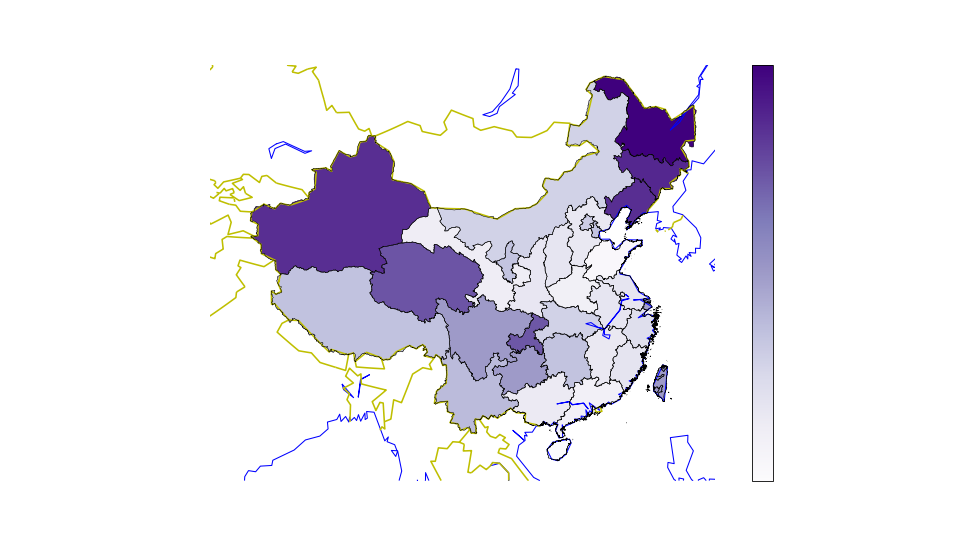

In [22]:
plot_map_fig(pos_data_dict, dpi=75)  # 颜色越深的地方离婚率相对越高